In [1]:
import qiskit
from scipy.stats import entropy
from scipy.spatial.distance import hamming
import pandas as pd
import copy
import numpy as np
from math import factorial
import matplotlib.pyplot as plt
from IPython import display
from itertools import permutations
import math
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict, defaultdict
import random
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.qpy import dump, load
from qiskit_aer import AerSimulator
import csv
import networkx as nx
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Circuits is a list of your circuits, result_bank is the corresponding
QiskitRuntimeService.save_account(channel="ibm_quantum", token="6a8f67dbf73b9c50c125d7d3b6baeecc3f84a80e6cdaa337b951979812e1ab855a4f162e5327a10bad296e00099dbd1cb01f029c7cbfe8a0f83bcc8ed7a46c90", set_as_default=True, overwrite=True)
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")  # Your IBM Backend here
sampler = SamplerV2(mode=backend)
random.seed(42)

In [3]:
def dec_to_countsVec(decimal, n_qubits, n_shots):
    res = [0] * (2**n_qubits)
    res[decimal] = n_shots
    return res

In [4]:
def get_rank_dict(data_dict, target):
    # Convert dict items to a list of (bit_string, value) pairs
    items = list(data_dict.items())
    # Sort by value in descending order
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
    
    # Create a mapping from bit string to rank (1-based)
    rank_map = {bit: rank+1 for rank, (bit, _) in enumerate(sorted_items)}
    
    # Return the rank of the target bit string
    return rank_map.get(target, None)  # Returns None if target not in dict

In [5]:
def plot_distribution(distribution, target=None, window=30):
    distribution = np.array(distribution)
    x = np.arange(len(distribution))

    if target is not None and 0 <= target < len(distribution):
        start = max(target - window // 2, 0)
        end = min(target + window // 2 + 1, len(distribution))
        x = x[start:end]
        distribution = distribution[start:end]
        colors = ['skyblue'] * len(distribution)
        colors[target - start] = 'red'
    else:
        colors = ['skyblue'] * len(distribution)

    plt.figure(figsize=(12, 5))
    plt.bar(x, distribution, color=colors)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Zoomed Distribution Around Target")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
def generate_binary_strings(bit_count):
    """
    Generate all possible binary strings of a given length.

    Args:
        bit_count (int): The length of the binary strings to be generated.

    Returns:
        list: A list of binary strings.
    """
    binary_strings = []

    def genbin(n, bs=''):
        """
        Recursive helper function to generate binary strings.

        Args:
            n (int): The remaining length of the binary string to be generated.
            bs (str): The current binary string generated so far.
        """
        if len(bs) == n:
            # The binary string has reached the desired length
            binary_strings.append(bs)
        else:
            # Recursive calls to append '0' or '1' and continue generating the binary string
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    # Start the generation process with an empty binary string
    genbin(bit_count)

    # Return the list of generated binary strings
    return binary_strings

In [7]:
def gen_ham_component(n, k):
    """
    Generate a binary string component with 'n' '1' characters and 'k' total length.

    Args:
        n (int): The number of '1' characters in the binary string.
        k (int): The total length of the binary string.

    Returns:
        str: The generated binary string component.

    Raises:
        AssertionError: If 'k' is not greater than 'n'.
    """
    # Ensure that 'k' is greater than 'n' using an assertion
    assert k > n

    # Generate the binary string component
    s1 = ''.join(['0' for _ in range(k - n)])  # Construct string of '0' characters
    s2 = ''.join(['1' for _ in range(n)])  # Construct string of '1' characters
    s = s1 + s2  # Concatenate the strings

    # Return the generated binary string component
    return s

In [8]:
def xor_convert(s1, s2):
    """
    Perform element-wise XOR operation on two binary strings.

    Args:
        s1 (str): The first binary string.
        s2 (str): The second binary string.

    Returns:
        str: The result of the XOR operation as a binary string.
    """
    # Perform the XOR operation element-wise using a list comprehension
    # If the XOR result is 1, append '1' to the result string; otherwise, append '0'
    result = ''.join(['1' if int(a) ^ int(b) == 1 else '0' for a, b in zip(s1, s2)])

    # Return the result of the XOR operation
    return result

In [9]:
def get_perms(n, k):
    """
    Get all binary strings of length 'k' with 'n' number of '1' characters.

    Args:
        n (int): The number of '1' characters in the binary strings.
        k (int): The length of the binary strings.

    Returns:
        list: A list of binary strings that satisfy the conditions.
    """
    bs = np.array(generate_binary_strings(k))  # Generate all binary strings of length 'k'
    nbs = []  # List to store the filtered binary strings

    for row in bs:
        if row.count('1') == n:
            # If the count of '1' characters in the binary string is equal to 'n', append it to the list
            nbs.append(row)

    return nbs  # Return the list of filtered binary strings

In [10]:
def hamming(s1, s2):
    """
    Calculate the Hamming distance between two binary strings.

    Args:
        s1 (str): The first binary string.
        s2 (str): The second binary string.

    Returns:
        int: The Hamming distance between the two strings.

    Raises:
        AssertionError: If the lengths of s1 and s2 are not equal.
    """
    assert len(s1) == len(s2), "The lengths of the binary strings must be equal."

    # Calculate the Hamming distance by counting the positions where the characters are different
    distance = sum(c1 != c2 for c1, c2 in zip(s1, s2))

    return distance

In [11]:
def p_failure(dq, sq, measurements, n_failure, t1, sqg_error, dqg_error, readout_err):
    """
    Calculate the probability of failure in a quantum system according to Q-BEEP

    Args:
        dq (int): Number of dq errors.
        sq (int): Number of sq errors.
        measurements (int): Number of measurements.
        n_failure (int): Number of failures.
        t1 (float): T1 relaxation time.
        sqg_error (float): SQ gate error rate.
        dqg_error (float): DQ gate error rate.
        readout_err (float): Readout error rate.

    Returns:
        float: The probability of failure.
    """
    p_fail = (1 - (((1 - readout_err) ** measurements) * ((1 - dqg_error) ** dq) * ((1 - sqg_error) ** sq) * (
        np.exp(-(1 * (sq + dq) / t1))))) ** n_failure

    return p_fail

In [12]:
def rand_key(p):
    """
    Generate a random binary string of a desired length.

    Args:
        p (int): The desired length of the binary string.

    Returns:
        str: The generated random binary string.
    """
    key1 = ""  # Variable to store the generated string

    for i in range(p):
        # Use the `random.randint` function to generate a random integer (0 or 1)
        # Convert the result into a string
        temp = str(random.randint(0, 1))

        # Concatenate the random 0 or 1 to the final result
        key1 += temp

    return key1  # Return the generated random binary string

In [13]:
def gen_bv_circ(s):
    """
    Generate a quantum circuit for the Bernstein-Vazirani algorithm.

    Args:
        n (int): The number of qubits in the circuit.
        s (str): The binary string representing the hidden binary string.

    Returns:
        qiskit.QuantumCircuit: The generated Bernstein-Vazirani circuit.
    """
    # Number of bits
    n = len(s)
    # Create a quantum circuit with n+1 qubits and n classical bits
    qc = QuantumCircuit(n + 1, n)
    
    # Apply X gate to the last qubit and then Hadamard gate
    qc.x(n)
    qc.h(range(n+1))

    qc.barrier()

    # Oracle for the Bernstein-Vazirani algorithm
    for i, bit in enumerate(reversed(s)):
        if bit == '1':
            qc.cx(i, n)

    qc.barrier()
    # Apply Hadamard gate to all qubits except the last one again
    qc.h(range(n+1))
    qc.barrier()

    # Measure the first n qubits
    qc.measure(range(n),range(n))
    # qc.draw(output='mpl')

    return qc  # Return the generated Bernstein-Vazirani circuit


In [14]:
def hamming_distance(chaine1, chaine2):
    """
    Calculate the Hamming distance between two strings.

    Args:
        chaine1 (str): The first string.
        chaine2 (str): The second string.

    Returns:
        int: The Hamming distance between the two strings.
    """
    # Calculate the Hamming distance by counting the positions where the characters are different
    distance = sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))

    return distance

In [15]:
def pad_zero(num, tlen):
    """
    Pad zeros to the left of a binary number to achieve a target length.

    Args:
        num (str): The binary number.
        tlen (int): The target length of the binary number.

    Returns:
        str: The padded binary number.
    """
    num = num.lstrip('0b')  # Remove the '0b' prefix from the binary number
    p_num = ''  # Variable to store the padded binary number

    for i in range(tlen - len(num)):
        p_num += '0'  # Append '0' to the padded binary number for the remaining length

    return p_num + num  # Concatenate the padded binary number with the original binary number


In [16]:
def gen_bins(num):
    """
    Generate binary strings representing a sequence of bins.

    Args:
        num (int): The number of bits in each binary string.

    Returns:
        list: A list of binary strings representing the sequence of bins.
    """
    bins = []  # List to store the generated binary strings

    # Generate the maximum binary string representation
    max_bin = '1'.join(['' for _ in range(num + 1)])

    # Iterate from 0 to the maximum binary value
    for i in range(int(eval('0b' + max_bin)) + 1):
        # Convert the decimal value to a binary string representation and pad zeros to match the specified length
        bins.append(pad_zero(bin(i), num))

    return bins

In [17]:
def hellinger_explicit(p, q):
    """
    Calculate the Hellinger distance between two discrete distributions.

    Args:
        p (list): The first discrete distribution.
        q (list): The second discrete distribution.

    Returns:
        float: The Hellinger distance between the two distributions.
    """
    list_of_squares = []  # List to store the squares of the differences

    for p_i, q_i in zip(p, q):
        # Calculate the square of the difference of the ith distribution elements
        s = (math.sqrt(p_i) - math.sqrt(q_i)) ** 2

        # Append the square to the list
        list_of_squares.append(s)

    # Calculate the sum of squares
    sosq = sum(list_of_squares)

    # Calculate the Hellinger distance by dividing the sum of squares by the square root of 2
    return sosq / math.sqrt(2)

In [18]:
def complete_results(r_dict: dict):
    """
    Complete the results dictionary by adding all possible binary keys that are not featured.

    Args:
        r_dict (dict): The results dictionary.

    Returns:
        dict: The completed results dictionary.
    """
    # Determine the number of bits based on the length of the keys in the dictionary
    n_bits = len(list(r_dict.keys())[0])

    # Generate a binary string with all bits set to '1'
    b_str = ''.join(['1' for _ in range(n_bits)])

    # Iterate from 0 to the maximum binary value
    for i in range(int(b_str, 2) + 1):
        # Convert the decimal value to a binary string representation and pad zeros if necessary
        key_b = bin(i).lstrip('0b').zfill(n_bits)

        # If the binary key is not present in the results dictionary, add it with a value of 0
        if key_b not in r_dict:
            r_dict[key_b] = 0

    return r_dict

In [19]:
def fid_class(dist_a, dist_b):
    """
    Calculate the fidelity between two probability distributions.

    Args:
        dist_a (list): The first probability distribution.
        dist_b (list): The second probability distribution.

    Returns:
        float: The fidelity between the two distributions.
    """
    fid = 0

    for a, b in zip(dist_a, dist_b):
        # Calculate the square root of the product of corresponding elements in the distributions
        fid += np.sqrt(a * b)
    return fid

In [20]:
def get_p_vals(backend, tc):
    """
    Retrieve properties and error rates from a backend and QEC for analysis.

    Args:
        backend: The backend to retrieve properties from.
        tc: The qubits indices that participate in the program

    Returns:
        tuple: A tuple containing t1, t2, sqg_error, dqg_error, and readout_err.
    """
    valid_indxs = set()

    # Extract valid indices from QEC data
    for dta in tc.data:
        dta = dta.qubits[0]._index
        valid_indxs.add(dta)


    aq = list(valid_indxs)
    properties = backend.properties().to_dict()
    t1 = []
    t2 = []
    readout_err = []
    
    # Retrieve T1, T2, and readout error rates for valid indices
    for qb in valid_indxs:
        t1.append(properties['qubits'][qb][0]['value'])
        t2.append(properties['qubits'][qb][1]['value'])
        readout_err.append(properties['qubits'][qb][4]['value'])

    
    t1 = np.mean(t1)
    t2 = np.mean(t2)
    readout_err = np.mean(readout_err)
    sqg = ['sx', 'x', 'rz']
    dqg = ['cx']
    sqg_error = []
    dqg_error = []

    # Retrieve gate error rates for valid indices and gate types
    for gate in properties['gates']:
        if len(gate['qubits']) == 1:
            if gate['qubits'][0] not in aq:
                continue
        else:
            if gate['qubits'][0] in aq and gate['qubits'][1] in aq:
                pass
            else:
                continue
        if gate['gate'] in sqg:
            if gate['parameters'][0]['name'] == "gate_error":
                sqg_error.append(gate['parameters'][0]['value'])
        elif gate['gate'] in dqg:
            if gate['parameters'][0]['name'] == "gate_error":
                val = gate['parameters'][0]['value']
                if val < 0.04:
                    dqg_error.append(val)
    
    sqg_error = np.mean(sqg_error)
    dqg_error = np.mean(dqg_error)
    # Return the extracted properties and error rates
    return t1, t2, sqg_error, dqg_error, readout_err

In [21]:
def poiss_params(dq, sq, measurements, t1, t2, sqg_error, dqg_error, readout_err, time):
    """
    Calculate the error count for a Poisson noise model based on various parameters and error rates.

    Args:
        dq (int): Number of dq errors.
        sq (int): Number of sq errors.
        measurements (int): Number of measurements.
        t1 (float): T1 relaxation time.
        t2 (float): T2 relaxation time.
        sqg_error (float): SQ gate error rate.
        dqg_error (float): DQ gate error rate.
        readout_err (float): Readout error rate.
        time (float): Time duration.

    Returns:
        float: The calculated error count.
    """
    ec = 0
    # Replace NaN with a default value (e.g., 0)
    dqg_error = dqg_error if not math.isnan(dqg_error) else 0
    sqg_error = sqg_error if not math.isnan(dqg_error) else 0
    
    # Calculate the error count based on the provided parameters and error rates
    ec += dqg_error * dq + sq * sqg_error + readout_err * measurements
    ec += measurements * np.exp(-t1 * 10 ** -6 / (time * 10 ** -9))
    ec += measurements * np.exp(-t2 * 10 ** -6 / (time * 10 ** -9))

    return ec

In [22]:
def poisson(lmda, k):
    """
    Calculate the probability mass function (PMF) of a Poisson distribution.

    Args:
        lmda (float): The average rate of occurrence.
        k (int): The number of events.

    Returns:
        float: The probability of obtaining 'k' events in the Poisson distribution.
    """
    # Calculate the PMF using the formula: lambda^k * e^(-lambda) / k!
    pmf = (lmda ** k) * np.exp(-lmda) / factorial(k)

    return pmf

In [23]:
def to_p_dist(results):
    """
    Convert a dictionary of results into a probability distribution.

    Args:
        results (dict): The dictionary of results.

    Returns:
        list: The probability distribution.
    """
    x = copy.deepcopy(results)  # Create a deep copy of the results dictionary
    tot = sum(x.values())  # Calculate the total sum of values in the dictionary

    # Normalize the values in the dictionary by dividing each value by the total sum
    for key in x:
        x[key] = x[key] / tot

    a = list(x.keys())  # Retrieve the keys (binary strings) from the dictionary
    bins = sorted(a, key=lambda z: int(z, 2))  # Sort the binary strings in ascending order based on their integer value

    res = []  # List to store the probability values

    # Retrieve the probability values corresponding to the sorted binary strings
    for bn in bins:
        res.append(x[bn])

    return res  # Return the probability distribution

In [24]:
def remove_idle_qwires(circ):
    """
    Remove idle quantum wires (qubits) from a given circuit.

    Args:
        circ (QuantumCircuit): The input circuit.

    Returns:
        QuantumCircuit: The modified circuit with idle wires removed.
    """
    dag = circuit_to_dag(circ)  # Convert the circuit to a directed acyclic graph (DAG)

    idle_wires = list(dag.idle_wires())  # Get the list of idle wires from the DAG
    for w in idle_wires:
        dag._remove_idle_wire(w)  # Remove the idle wire from the DAG
        dag.qubits.remove(w)  # Remove the idle wire from the qubits attribute of the DAG

    dag.qregs = OrderedDict()  # Set the qregs attribute of the DAG to an empty OrderedDict

    return dag_to_circuit(dag)  # Convert the modified DAG back to a circuit and return it

In [25]:
def bernstein_vazirani(binary_string, shots):
    # Number of bits
    n = len(binary_string)
    # Create a quantum circuit with n+1 qubits and n classical bits
    qc = QuantumCircuit(n + 1, n)
    
    # Apply X gate to the last qubit and then Hadamard gate
    qc.x(n)
    qc.h(range(n+1))

    qc.barrier()

    # Oracle for the Bernstein-Vazirani algorithm
    for i, bit in enumerate(reversed(binary_string)):
        if bit == '1':
            qc.cx(i, n)

    qc.barrier()
    # Apply Hadamard gate to all qubits except the last one again
    qc.h(range(n+1))
    qc.barrier()

    # Measure the first n qubits
    qc.measure(range(n),range(n))
    # qc.draw(output='mpl')

    # Transpile the circuit for the simulator
    compiled_circuit = transpile(qc, backend)
    # Run the simulation
    result = sampler.run([compiled_circuit], shots=shots).result()
    # Get the measurement results
    counts = result[0].data.c.get_counts()
    
    return qc, counts

In [26]:
def hamming_bin(binary_string, shots, counts):
    # true_result = list(binary_string)
    hamming_Count = defaultdict(int)
    hamming_Probs = defaultdict(int)
    neighbor_list = {}
    bin_props = {}

    for obs_str, count in counts.items():
        hamming_dist = int(hamming(obs_str, binary_string))
        hamming_Count[hamming_dist] += count
        hamming_Probs[hamming_dist] = (hamming_Count[hamming_dist] / shots)
        if hamming_dist in neighbor_list:
            neighbor_list[hamming_dist].append(obs_str)
        else:
            neighbor_list[hamming_dist] = [obs_str]
        bin_props[obs_str] = (count/shots)

    for h_dist, count  in hamming_Count.items():
        hamming_Count[h_dist] = count/len(neighbor_list[h_dist])

    for h_dist, prob in hamming_Probs.items():
        hamming_Probs[h_dist] = prob/len(neighbor_list[h_dist])

    neighbor_list = dict(sorted(neighbor_list.items()))
    hamming_Count = dict(sorted(hamming_Count.items()))
    hamming_Probs = dict(sorted(hamming_Probs.items()))
    bin_props = dict(sorted(bin_props.items()))
    counts = dict(sorted(counts.items()))

    return hamming_Count, hamming_Probs, bin_props, counts, neighbor_list

In [27]:
def bayesian_graph(data):
    # Create a directed graph
    G = nx.DiGraph()
    
    # Process each node and its neighbors
    for node, edges in data.items():
        for neighbor, weight in edges.items():
            # Add the edge in both directions with different weights for demonstration
            G.add_edge(node, neighbor, weight=weight)
            G.add_edge(neighbor, node, weight=weight * 1.2)  # Example: Modified weight in reverse direction

    # Extract edge labels for visualization
    edge_labels = {(u, v): f"{d['weight']:.4f}" for u, v, d in G.edges(data=True)}

    # Draw the graph with labels and weights
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.title('Two-Way Bayesian Connected Graph')
    plt.show()

    return G

In [28]:
def graph_bins(counts_dict_1, counts_dict_2):    
    # Extract keys and values for the first dictionary
    x1 = list(counts_dict_1.keys())
    y1 = list(counts_dict_1.values())

    # Extract keys and values for the second dictionary
    x2 = list(counts_dict_2.keys())
    y2 = list(counts_dict_2.values())

    # Create a scatter plot with connected lines for both datasets
    plt.figure(figsize=(8, 5))

    # Plot for counts_dict_1
    plt.scatter(x1, y1, color='red', label='Original Points')
    plt.plot(x1, y1, color='blue', linestyle='-', label='Original Line')

    # Plot for counts_dict_2
    plt.scatter(x2, y2, color='green', label='QBeep Points')
    plt.plot(x2, y2, color='orange', linestyle='--', label='QBeep Line')

    # Customizations
    plt.xlabel('Hamming Distance')
    plt.ylabel('Counts')
    plt.title('Comparison of Hamming Distance Bins for Two Datasets')
    plt.xticks(sorted(set(x1 + x2)))  # Ensure all keys from both datasets are labeled
    plt.legend()
    plt.show()

In [29]:
def graph_bstr(result, bstr):
    # Key to highlight
    highlight_key = bstr

    # Extract keys and values
    x = list(result.keys())
    y = list(result.values())

    # Create bar colors: highlight specific key in a different color
    colors = ['orange' if key == highlight_key else 'blue' for key in x]

    # Plot the bar graph
    plt.figure(figsize=(8, 5))
    plt.bar(x, y, color=colors)

    # Customizations
    plt.xlabel('Hamming Distance')
    plt.ylabel('Counts')
    plt.title('Hamming Distance Counts with Highlighted Key')
    plt.xticks(x)
    plt.show()

In [30]:
from itertools import permutations

def generate_binary_string(length, ones):
    if ones > length:
        return "Number of ones cannot exceed the length."
    # Create a base list of 0's and 1's
    binary_list = [1] * ones + [0] * (length - ones)
    # Generate all unique permutations
    binary_permutations = set(permutations(binary_list))
    # Convert each permutation to a string
    binary_strings = [''.join(map(str, perm)) for perm in binary_permutations]
    return binary_strings

In [31]:
def get_rank(bstr, result):
    sorted_items = sorted(result.items(), key=lambda x: x[1],reverse=True)
    rank_dict = {key: rank + 1 for rank, (key, _) in enumerate(sorted_items)}
    return rank_dict[bstr], sorted_items

In [32]:
def normalize(result):
    total = sum(result.values())
    p_distribution_dict = {k: v / total for k, v in result.items()}
    return p_distribution_dict

In [33]:
# Create a new dict with {bstr: prob}
def newResultDict(test_case):
    dict = {"secret_string":test_case}
    stringArray = ["0"] * len(test_case)
    string = "".join(stringArray)
    while(True):
        dict[string] = 0
        if(string == "1" * len(test_case)):
            break
        for i in range(len(string)):
            if string[i] == "0":
                if string[i+1:].find("0") == -1:
                    stringArray[i] = "1"
                    for v in range(i + 1, len(test_case)):
                        stringArray[v] = "0"
                    string = "".join(stringArray)
                    break
    return dict

In [34]:
# Function to predict the most likely outcome (binary string)
def predict_binary_string(predictions, num_qubits):
    # Get the index of the maximum probability
    max_index = torch.argmax(predictions).item()

    # Convert index to corresponding binary string
    result_string = bin(max_index)[2:].zfill(num_qubits)
    return result_string

In [35]:
# Function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = 0
    total = len(predictions)

    for predicted, true in zip(predictions, ground_truth):
        
        # Compare the predicted binary string with the true label
        if predicted == true:
            correct += 1

    accuracy = correct / total
    return accuracy

In [36]:
# circuits = [
#     bernstein_vazirani('1010', 10240),
#     bernstein_vazirani('10011', 10240),
#     bernstein_vazirani('110000', 10240),
#     bernstein_vazirani('1000001',10240),
#     bernstein_vazirani('11001001', 10240),
#     bernstein_vazirani('110000011', 10240)]  # Your list of circuits here


# for i in range(len(circuits)):
#     file_name = f'bv_circuit_{i}.qpy'
#     with open(file_name, 'wb') as file:
#         dump(circuits[i][0], file)
#     print("Circuit", i+1 ,"saved!")

#     file_name = f'bv_counts_{i}.csv'
#     with open(file_name, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         for key, value in circuits[i][1].items():
#             writer.writerow([key, value])

In [37]:
# circuit_list = []
# result_bank = []

# for i in range(6):
#     file_name = f'bv_circuit_{i}.qpy'
#     with open(file_name, 'rb') as file:
#         circuit = load(file)[0]

#     circuit_list.append(circuit)
    
    
#     file_name = f'bv_counts_{i}.csv'
#     counts = {}
#     with open(file_name, mode='r', newline='') as file:
#         reader = csv.reader(file)
#         for row in reader:
#             counts[row[0]] = int(row[1])
#     result_bank.append(counts)
    

In [38]:
def QBeep(circuit, results, target_bstr):
    initial_state = copy.deepcopy(results)
    # print(initial_state)

    bit_string_neighbors = {}

    # Iterate over the range of bit string lengths
    for i in range(5, 16):
        # Iterate over the range of indices for each bit string length
        for j in range(i - 1):
            # Check if the length key exists in the outer dictionary
            if str(i) not in bit_string_neighbors:
                bit_string_neighbors[str(i)] = {}

            # Check if the index key exists in the inner dictionary
            if str(j) not in bit_string_neighbors[str(i)]:
                # Generate and store the neighbors of the bit string with the given length and index
                s = get_perms(j, i)
                bit_string_neighbors[str(i)][str(j)] = s
                # print(f"Added {i=}, {j=}: {s}")  # Debug print inside the loop
            else:
                # Retrieve the stored neighbors from the inner dictionary
                s = bit_string_neighbors[str(i)][str(j)]

    # For evaluation, we include a simulation to understand the correct distribution.
    # This part is to get the distribuition of counts
    sim = AerSimulator()

    sim_result = sim.run(circuit, shots=10240).result()  # Execute with 10240 shots
    ideal_res = sim_result.get_counts(circuit)
    corr_soln = list(ideal_res.keys())[0]
    ideal_res = complete_results(ideal_res)
    ideal_res = to_p_dist(ideal_res)

    # This part try out count the operation 'cx', can ignore until use the pparam below
    try:
        dq = circuit.count_ops()['cx']
    except:
        dq = 0

    # This part get number of gate of operation
    ops = circuit.count_ops()
    if 'cx' in ops.keys():
        sq = sum(ops.values()) - ops['barrier'] - ops['cx'] - ops['measure']
    else:
        sq = sum(ops.values()) - ops['barrier'] - ops['measure']
    measurements = ops['measure']

    # t1: Time constant for energy relaxation from |1⟩ to |0⟩
    # t2: Time constant for phase decoherence, causing loss of quantum information without energy loss.
    # sqg_error: Single-Qubit Gate Error
    # dqg_error: Two-Qubit Gate Error
    # readout_err: Readout Error
    compiled_circuit = transpile(circuit, backend)
    t1, t2, sqg_error, dqg_error, readout_err = get_p_vals(backend, circuit)
    time = qiskit.schedule(compiled_circuit, backend).stop_time
    pparam = poiss_params(dq, sq, measurements, t1, t2, sqg_error, dqg_error, readout_err, time)

    if results[corr_soln] == 0:
        # QBEEP is not applicable to
        print(f"This solution observed no correct bs.")

    # Calculate the cut_off value according to the size of results bank since further away result are insignificant
    # If PMF is high, peak flag is raised
    results = complete_results(results)
    p_prior = results[corr_soln] # an initial estimate of the likelihood of an error occurring before any measurements are taken.
    nb = len(list(results.keys())[0]) # number of bin string of given num bit
    peaked = False
    cut_off = nb

    for i in range(nb):
        if i > (nb/2):
            cut_off = i - 1
            break
        # Arbitrary for debugging
        if poisson(pparam, i) > 0.2:
            peaked = True
        if poisson(pparam, i) < 0.05 and peaked:
            cut_off = i
            break
    
    # Calculate the fidelity by measuring how much the system deviates from the intended state due to noise or errors
    p_dist_corr = to_p_dist(results.copy())

    fidelities = []
    fidelities.append([])
    fidelities[-1].append(fid_class(p_dist_corr, ideal_res))

    # This is the most computationally costly section of our algorithm.
    # Current versions populate 2^n bins. This is not necessary, as you only need
    # to populate up to k bins, where k is the number of observations you made on your circuit.
    # We did not do this optimization in the code. But the change can be made for the same results.
    nn = {}
    for key in results.keys():
        if results[key] == 0:
            nn[str(key)] = {}
            continue
        for i in np.arange(1, cut_off):
            s = bit_string_neighbors[str(nb)][str(i)]
            if key not in nn:
                nn[str(key)] = {}
            nn[str(key)][str(i)] = []
            for ham in s:
                z = xor_convert(ham, key)
                nn[str(key)][str(i)].append(z)


    # For this, we are generating the dictionary of P(A|B) = P(B|A)*P(A)/P(B)
    # In each iteration, P(A) is each result key, and P(B) is a H Dist away bitstring
    # i.e. the Deltas objects keys represent the probability of each result belonging to Key
    # given that we observed Bstr. This is computed as P(Bstr Observed Model)*P(Class)/P(Bstr Observed)
    deltas = {}
    for UPDATE in range(20):
        lr = 1 / (UPDATE + 1)
        for key in results.keys():
            deltas[key] = {}
            if results[key] != 0:
                for h_dist in nn[key]:
                    hdist = poisson(pparam, int(h_dist))
                    # Iterate over each bitstring nn[key] distance away (HAMMING)
                    for bstr in nn[key][h_dist]:
                        # If initial_state[bstr] != 0
                        if results[key] != 0:
                            deltas[key][bstr] = hdist * results[bstr] / results[key]
                        else:
                            deltas[key][bstr] = 0
                tot = sum(deltas[key].values())
                if tot > 1:
                    for bstr in deltas[key].keys():
                        deltas[key][bstr] = deltas[key][bstr] / tot
        

        # In this algorithm, we iterate over each key in the updates dictionary.
        # Over each iteration, we take the update key, and the bistrstring corersponding
        updates = copy.deepcopy(deltas)
        for change_key in updates.keys():
            for bstr in updates[change_key].keys():
                updates[change_key][bstr] = int(lr * updates[change_key][bstr] * results[change_key])
            tchange = sum(updates[change_key].values())
            cap = results[change_key]
            if tchange > cap:
                for bstr in updates[change_key].keys():
                    updates[change_key][bstr] = int(updates[change_key][bstr] * cap / tchange)

        change = {}
        for key in updates:
            change[key] = {}
            change[key]['out'] = sum(updates[key].values())
            change[key]['in'] = 0
            for out_key in updates.keys():
                if out_key == key:
                    continue
                elif key in updates[out_key]:
                    change[key]['in'] += updates[out_key][key]
        for key in change:
            results[key] = results[key] - change[key]['out'] + change[key]['in']

        p_dist_corr = to_p_dist(results)
        
        # for i, key in enumerate(results.keys()):
        #     results[key] = p_dist_corr[i]

        fidelities[-1].append(fid_class(p_dist_corr, ideal_res))
    
        
    # org_val = hamming_bin(target_bstr, 10240, initial_state)
    # fin_val = hamming_bin(target_bstr, 10240, results)
    # graph_bins(org_val[0], fin_val[0])
    # print("Original")
    # graph_bstr(initial_state, target_bstr)
    # print("QBeep")
    # graph_bstr(results, target_bstr)
    # print("Target string: ", target_bstr)
    # print("Rank before: ", get_rank(target_bstr, initial_state))
    # print("Rank after: ", get_rank(target_bstr, results))
    # print("Fidelities:\n", fidelities)

    return p_dist_corr, fidelities


Testing Q_Beep

In [72]:
n = 9

key_list = []
result_bank = []

file_name = f'1_7-ones_9qubitsBV.csv'
with open(file_name, 'r', newline='') as csvfile:
    resultDict = newResultDict("0" * n)
    reader = csv.DictReader(csvfile, fieldnames = resultDict.keys())
    for row in reader:
        key_list.append(row['secret_string'])
        result_bank.append({k: int(v) for k, v in list(row.items())[1:]})

data_dicts = []
for i in range(len(key_list)):
    temp = {}
    temp["input"] = result_bank[i]
    temp["target"] = key_list[i]
    data_dicts.append(temp)

In [73]:
data_dicts = data_dicts[::-1]

In [74]:
rank_list_b4 = []
for i in range(len(data_dicts)):
    rank_list_b4.append(get_rank_dict(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list_b4 = np.array(rank_list_b4)
rank_list_b4

array([ 1,  1,  1,  1,  1,  7,  2,  1,  1,  8,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 30, 15, 11,  1, 19,  7,  2,  2, 29,  2, 15,  2,  1,
        1,  1,  1, 18, 13,  4,  1,  3,  5,  2,  1,  5,  1,  7,  1,  1,  1,
        1,  1, 50, 26,  1,  1,  3,  1,  2,  1,  3,  1,  5,  1,  1,  1,  1,
        1, 52,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       65,  1,  1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  4,  1,  1,  1,  1,
        1,  1,  1,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [75]:
X = []
y = []
for i in range(len(data_dicts)):
    X.append([j for j in data_dicts[i]['input'].values()])
    y.append(data_dicts[i]['target'])

X = np.array(X)
X = X / X.sum(axis=1, keepdims=True)  # Normalizing noisy counts to sum to 1
X_tensor = torch.tensor(X, dtype=torch.float32)
target_bits = copy.deepcopy(y)

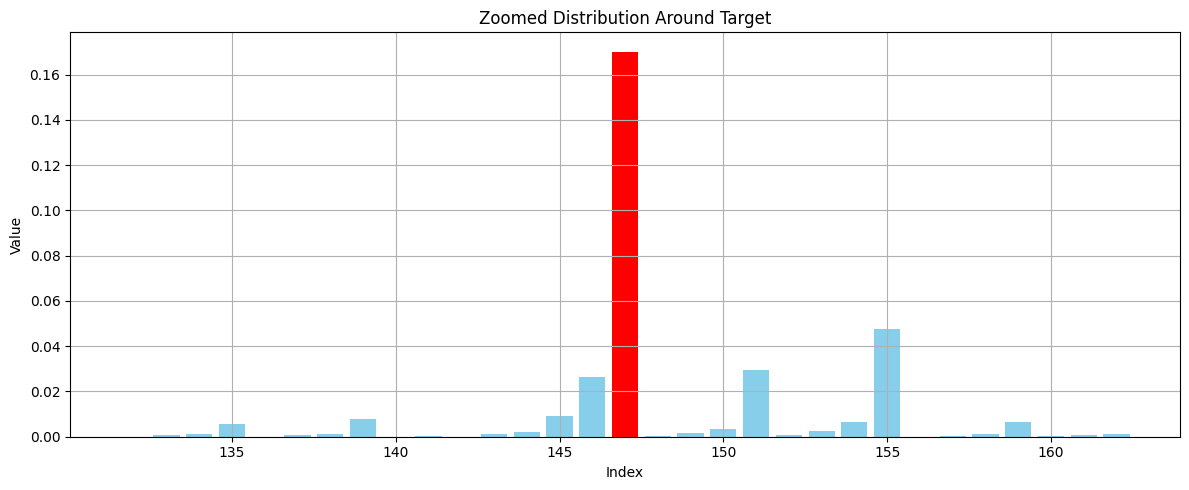

In [76]:
plot_distribution(X[1], int(y[1], 2))

In [77]:
original_predict = []
for i in range(len(X_tensor)):
    predicted_string = predict_binary_string(torch.tensor(X_tensor[i]), num_qubits=9)
    original_predict.append(predicted_string)
    
calculate_accuracy(original_predict, y)

/tmp/ipykernel_348652/2363816458.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_string = predict_binary_string(torch.tensor(X_tensor[i]), num_qubits=9)


0.7516778523489933

In [78]:
for i in range(len(y)):
    y[i] = dec_to_countsVec(int(y[i],2), n, 10240)

y = np.array(y)
y = y / y.sum(axis=1, keepdims=True)  # Normalizing ideal counts to sum to 1
y_tensor = torch.tensor(y, dtype=torch.float32)

In [79]:
pred = X_tensor.cpu().numpy()
true = y_tensor.cpu().numpy()
fidelities = [fid_class(p, t) for p, t in zip(pred, true)]

In [80]:
fidelities = np.array(fidelities)
average_fid = np.mean(fidelities)
average_fid

np.float32(0.5967754)

In [81]:
q_beep_dist = []
q_beep_fidelity = []
for i in range(len(data_dicts)):
    circuit = gen_bv_circ(data_dicts[i]['target'])
    q_beep_dist.append(QBeep(circuit, data_dicts[i]['input'], data_dicts[i]['target'])[0])
    q_beep_fidelity.append(QBeep(circuit, data_dicts[i]['input'], data_dicts[i]['target'])[1])

In [88]:
new_predict = []
for i in range(len(q_beep_dist)):
    predicted_string = predict_binary_string(torch.tensor(q_beep_dist[i]), num_qubits=9)
    new_predict.append(predicted_string)
    
calculate_accuracy(new_predict, target_bits)

0.7516778523489933

In [89]:
for i in range(len(data_dicts)):
    keys = list(data_dicts[i]["input"].keys())
    values = q_beep_dist[i]  
    data_dicts[i]["input"] = dict(zip(keys, values))

In [90]:
rank_list_after = []
for i in range(len(data_dicts)):
    rank_list_after.append(get_rank_dict(data_dicts[i]["input"], data_dicts[i]["target"]))
rank_list_after = np.array(rank_list_after)
rank_list_after

array([ 1,  1,  1,  1,  1,  7,  2,  1,  1,  7,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 30, 32, 30,  1, 15,  5,  2,  2, 28,  3, 15,  2,  1,
        1,  1,  1, 26, 22,  4,  1,  3,  5,  2,  1,  6,  1,  6,  1,  1,  1,
        1,  1, 35, 12,  1,  1,  2,  1,  4,  1,  3,  1,  5,  1,  1,  1,  1,
        1, 66,  5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       67,  1,  1,  1,  5,  1,  1,  1,  1,  1,  2,  1,  4,  1,  1,  1,  1,
        1,  1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,  1,
        2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [91]:
increase = 0
decrease = 0
for i in range(len(rank_list_b4)):
    if rank_list_b4[i] < rank_list_after[i]:
        decrease += 1
    if rank_list_b4[i] > rank_list_after[i]:
        increase += 1
increase, decrease

(8, 13)

In [92]:
fidelities = np.array(q_beep_fidelity)
average_fid = np.mean(fidelities)
average_fid

np.float64(0.7639709776672126)

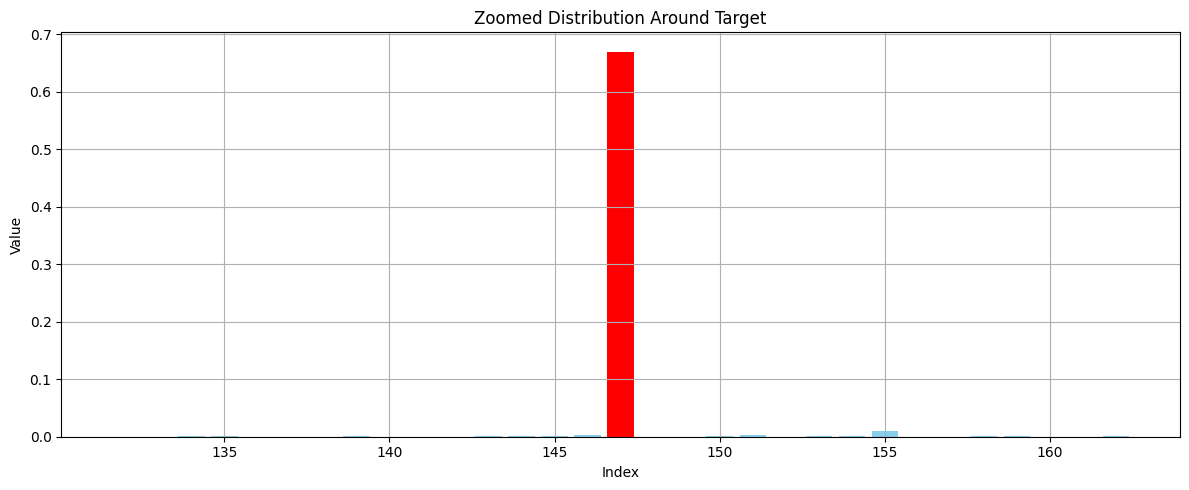

In [93]:
plot_distribution(q_beep_dist[1], int(target_bits[1], 2))